In [51]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import re
sns.set(color_codes=True)
%matplotlib inline

In [52]:
experiments = [
    #{'id': "14", 'train_id': "8", 'name': 'squeezenet' }, 
    #{'id': "7", 'name': 'lenet' }, 
    {'id': "3", 'train_id': "3", 'name': 'pruned-resnet18' },
    #{'id': "10", 'train_id': "3", 'name': 'resnet18' }, 

    #{'id': "11", 'name': 'lenetplus' },
    #{'id': "17", 'name': 'lenet_cinic' },

]

In [85]:
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
runs = []

EXP_ID = "11"
QUANT_EXP_ID = "11"

pruning = mlflow.search_runs(
  experiment_ids=EXP_ID,
  filter_string="tags.pruning_method = 'unstructured_l1' and tags.type = 'pruning'",
  output_format="pandas",
).iloc[1]
train = mlflow.search_runs(
  experiment_ids=EXP_ID,
  filter_string="tags.stage = 'train'",
  output_format="pandas",
  max_results=1,
).iloc[0]
quant = mlflow.search_runs(
  experiment_ids=QUANT_EXP_ID,
  filter_string="tags.type = 'quantization'",
  output_format="pandas",
)
quant = quant[quant["params.quantization/activation_precision"] == "7"]

prun_quant = mlflow.search_runs(
  experiment_ids=EXP_ID,
  filter_string="tags.type = 'pruning + quantization'",
  output_format="pandas",
)

In [86]:
results = []

patt = re.compile(r"metrics.p_(0\.\d+)_test/acc")
for key in pruning.keys():
    if patt.match(key):
        patt2 = re.compile(r'0\.\d+')
        result = { 'type': 'pruning', 'model_size': float(patt2.search(key)[0]), 'acc_loss': pruning[key] - train["metrics.test/acc"]}
        results.append(result)


In [87]:
for i in range(len(quant)):
    run = quant.iloc[i]
    result = {"type": 'quantization', 'model_size': int(run["params.quantization/weight_precision"]) / 32, 'acc_loss': run["metrics.q_test/acc"] - train["metrics.test/acc"]}
    results.append(result)

for i in range(len(prun_quant)):
    run = prun_quant.iloc[i]
    base_size = float(run["tags.pruning_amount"])
    quant_size = int(run["params.quantization/weight_precision"]) / 32

    result = {"type": 'pruning + quantization', 'model_size': base_size * quant_size, 'acc_loss': run["metrics.q_test/acc"] - train["metrics.test/acc"]}
    results.append(result)

In [88]:
df = pd.DataFrame(results)

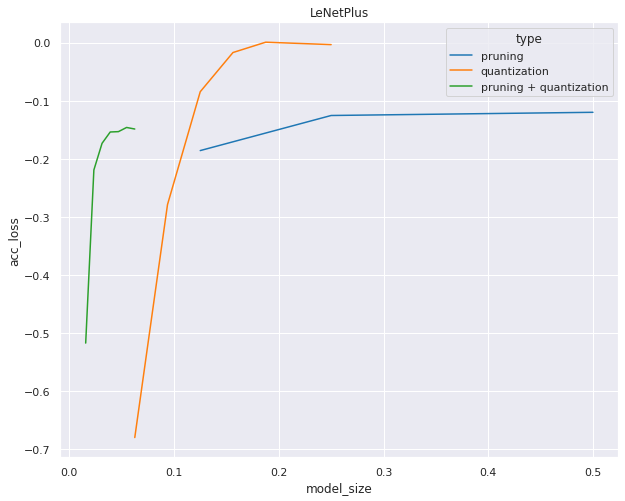

In [89]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")
sns.lineplot(data=df, x="model_size", y="acc_loss", hue="type", dashes=False)
plt.title("LeNetPlus")
plt.savefig("./data/comparison/lenetplus.jpg")
